In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, RocCurveDisplay
import xgboost as xgb

In [10]:
# DATA PREPROCESSING
df = pd.read_csv('MalwareData.csv', sep='|')
print("Total samples: ", len(df))
print("Total number of attributes: ", len(df.columns))

# remove unnecessary attributes
malware_df = df.drop(['Name', 'md5', 'Machine', 'LoaderFlags', 'NumberOfRvaAndSizes', 'CheckSum', 'SizeOfOptionalHeader', 'SizeOfHeaders'], axis=1)

labels = malware_df['legitimate'] #labels

# since the dataset is imbalanced, undersample the malware samples
legit = malware_df[labels == 1].copy()
mal = malware_df[labels  == 0].copy()

mal_shuffle = mal.sample(frac=1, random_state=42)
rows = mal_shuffle.index[0:(len(mal) - len(legit))]
mal_trimmed = mal_shuffle.drop(rows)

trimmed_mal_df = pd.concat([legit, mal_trimmed], ignore_index=True)
trimmed_mal_df = trimmed_mal_df.sample(frac=1, random_state=42)
print("Total samples after undersampling: ", len(trimmed_mal_df))
print("Total number of attributes after: ", len(trimmed_mal_df.columns))

attributes = trimmed_mal_df.columns.to_numpy() # get the attributes 
attributes = np.delete(attributes, -1) # remove labels from dataset

X = trimmed_mal_df[attributes] #attributes
y = trimmed_mal_df['legitimate'] #labels

# Used PCA to get rid of unnecessary features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

Total samples:  138047
Total number of attributes:  57
Total samples after undersampling:  82646
Total number of attributes after:  49


In [11]:
# TRAINING THE MODEL
# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# create an instance of the XGBoost algorithm
model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, objective='binary:logistic')
model.fit(X_train, y_train) # fit the model to the training data
y_pred = model.predict(X_test) # make predictions on the test set

Accuracy:  98.86
Precision score:  98.69
Recall score:  99.04
F-1 score:  98.87


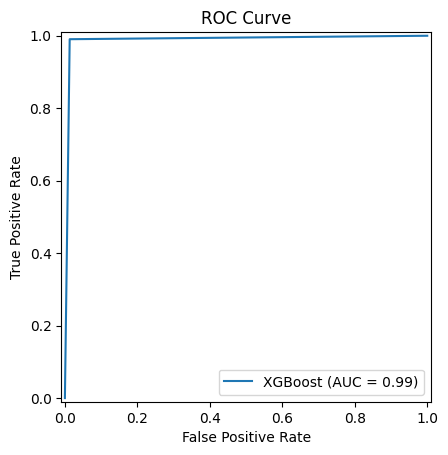

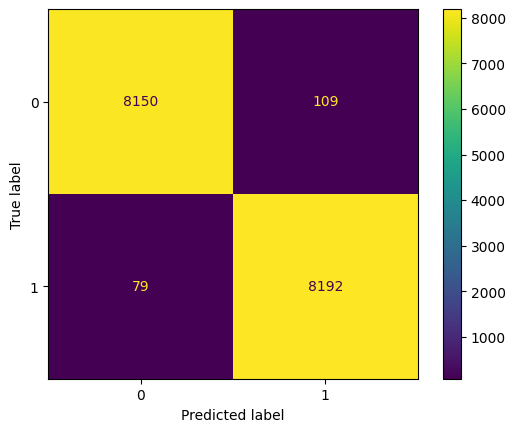

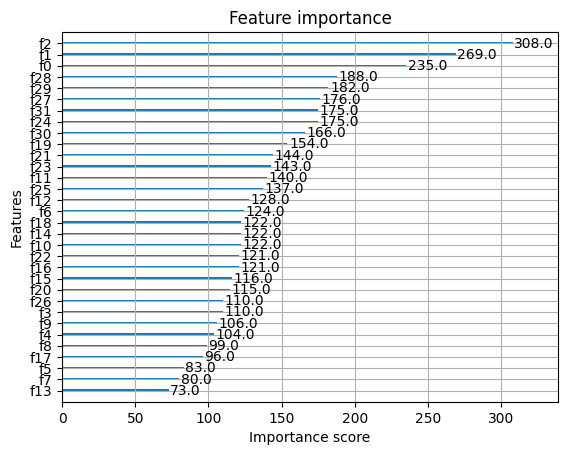

In [12]:
# METRICS
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", round(accuracy*100, 2))

precision = precision_score(y_test, y_pred)
print("Precision score: ", round(precision*100, 2))

recall = recall_score(y_test, y_pred)
print("Recall score: ", round(recall*100, 2))

f1_score = f1_score(y_test, y_pred)
print("F-1 score: ", round(f1_score*100, 2))

#ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, name='XGBoost')
display.plot()
plt.title('ROC Curve')
plt.show()

#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

xgb.plot_importance(model)
plt.show()